### 171EC146 Sathvik S Prabhu

## Q1
Generate the English vowel speech and sounds, find the lpc coefficients of these sounds using the both autocorrelation and covariance method and spectrum of linear models which are functions of lpc coefficients. 

In [2]:
# Autocorrelation method
import librosa
import numpy as np
import scipy as sp
import scipy.signal as sig
import matplotlib.pyplot as plt
import IPython.display as ipd

def lpc_ref(signal, order):

    if order > 0:
        p = order + 1
        r = np.zeros(p, signal.dtype)
        nx = np.min([p, signal.size])
        x = np.correlate(signal, signal, 'full')
        r[:nx] = x[signal.size-1:signal.size+order]
        phi = np.dot(sp.linalg.inv(sp.linalg.toeplitz(r[:-1])), -r[1:])
        return np.concatenate(([1.], phi))
    else:
        return np.ones(1, dtype = signal.dtype)

def lpc_levinson(r, order):
    
    r = np.atleast_1d(r)
    n = r.size
    
    # Estimated coefficients
    a = np.empty(order+1, r.dtype)
    # temporary array
    t = np.empty(order+1, r.dtype)
    # Reflection coefficients
    k = np.empty(order, r.dtype)

    a[0] = 1.
    e = r[0]

    for i in range(1, order+1):
        acc = r[i]
        for j in range(1, i):
            acc += a[j] * r[i-j]
        k[i-1] = -acc / e
        a[i] = k[i-1]

        for j in range(order):
            t[j] = a[j]

        for j in range(1, i):
            a[j] += k[i-1] * np.conj(t[i-j])

        e *= 1 - k[i-1] * np.conj(k[i-1])

    return a, e, k

In [13]:
data, fs = librosa.load("a.wav", sr=8000)
print("Length of data: ",len(data))
print("Sampling frequency: ",fs)
ipd.Audio("a.wav")

Length of data:  8453
Sampling frequency:  8000


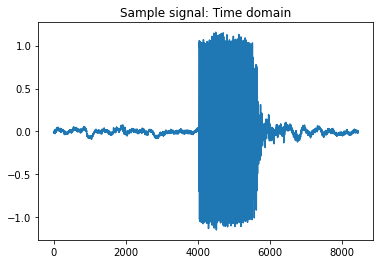

In [4]:
plt.plot(data)
plt.title("Sample signal: Time domain")
plt.show()

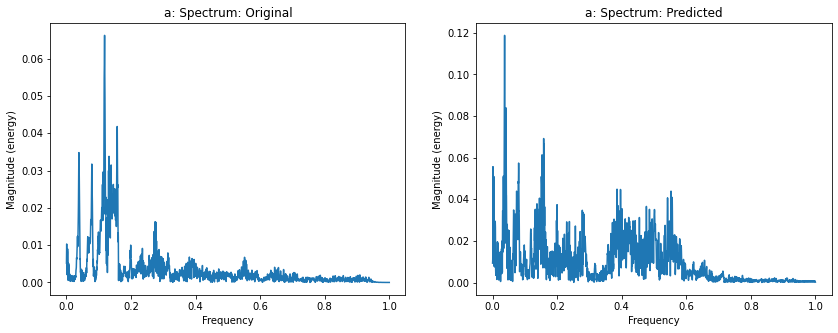

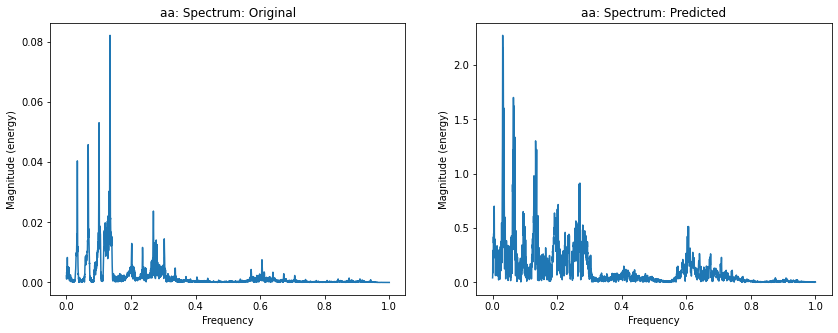

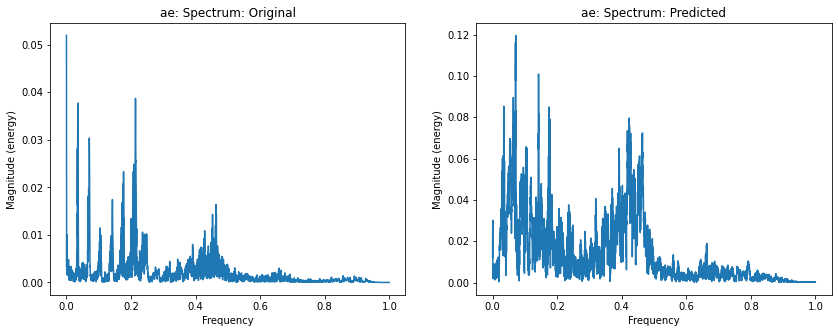

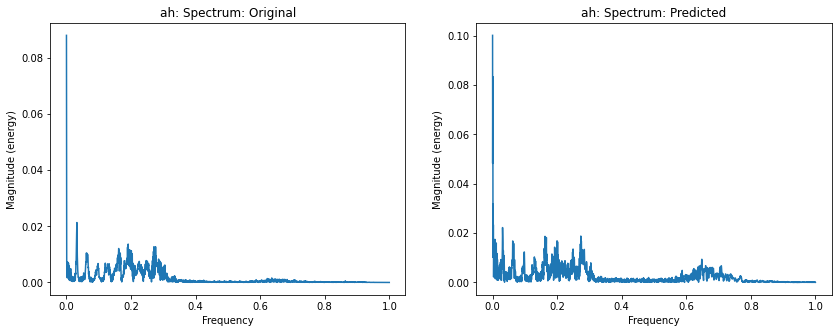

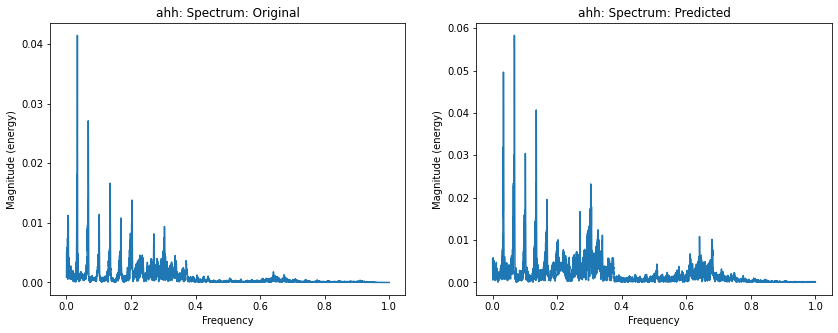

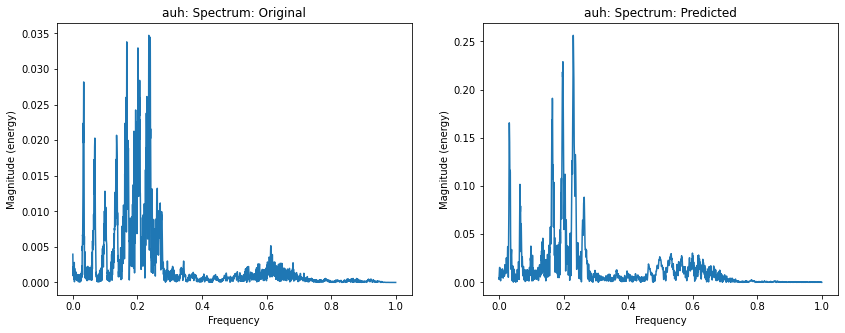

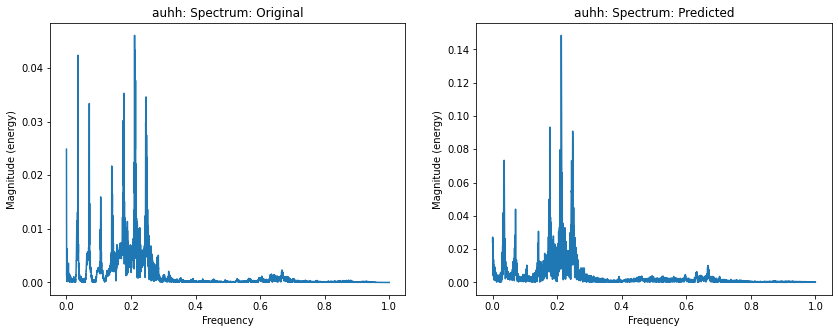

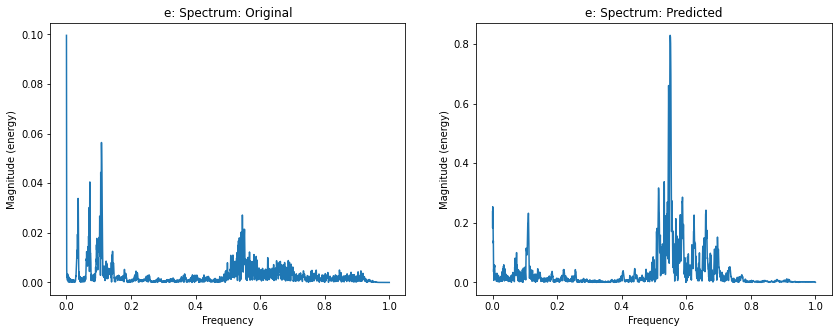

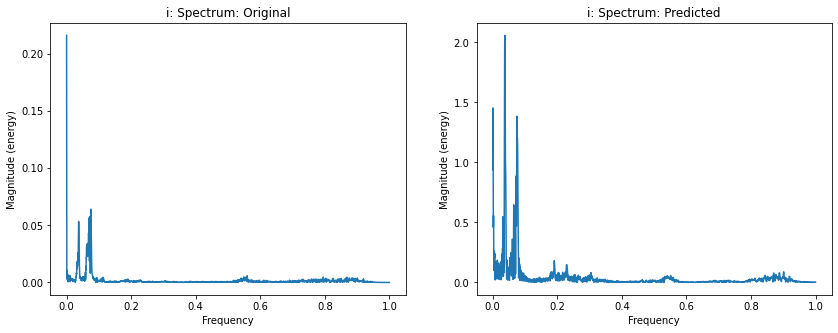

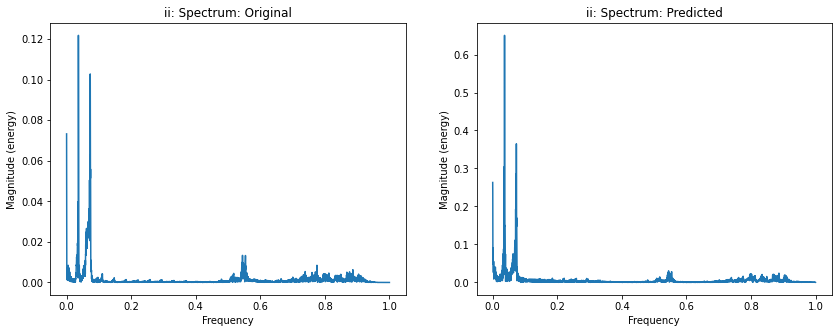

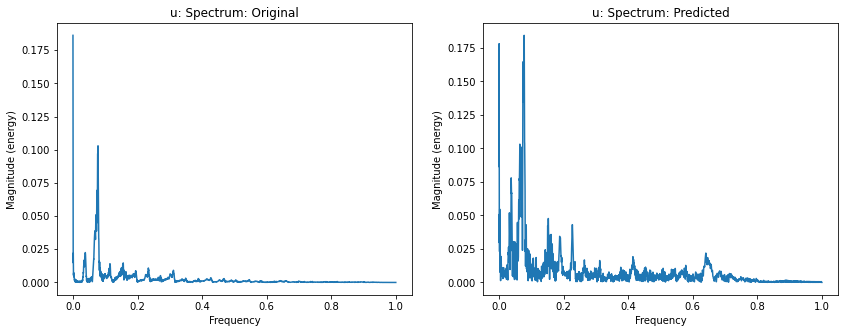

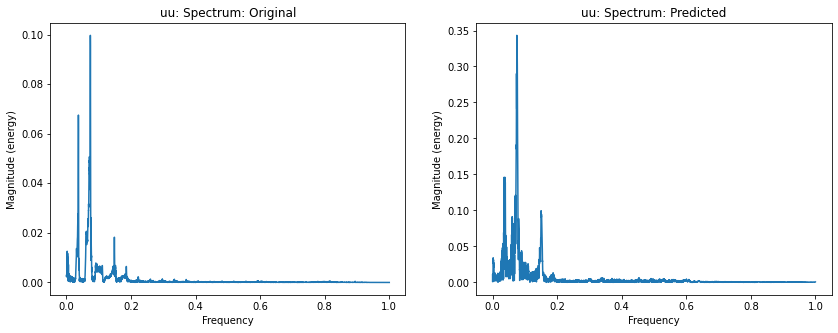

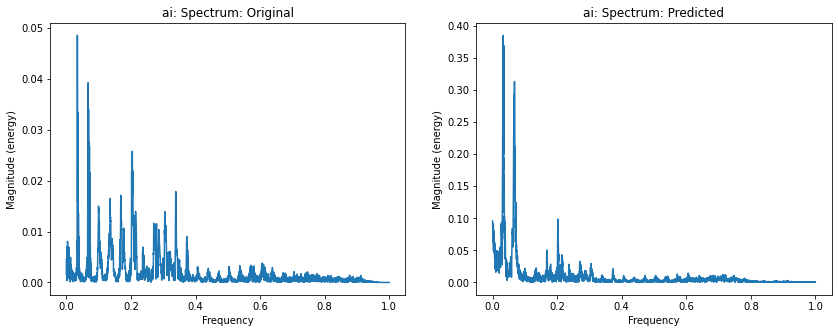

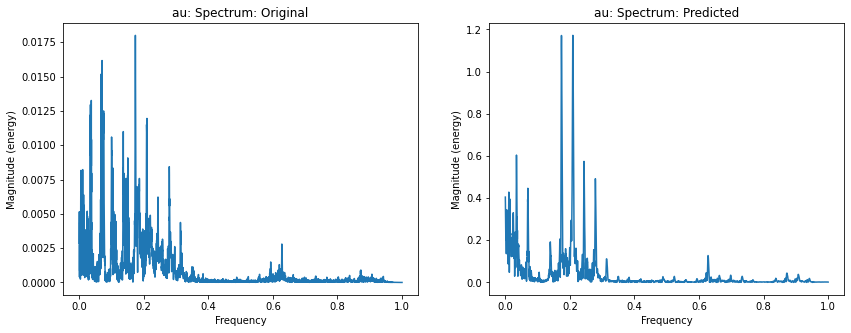

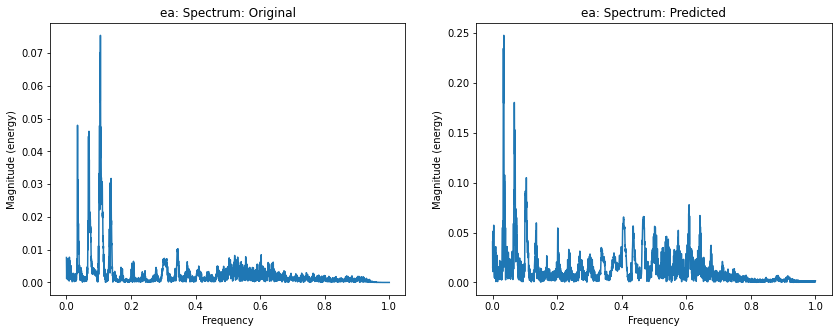

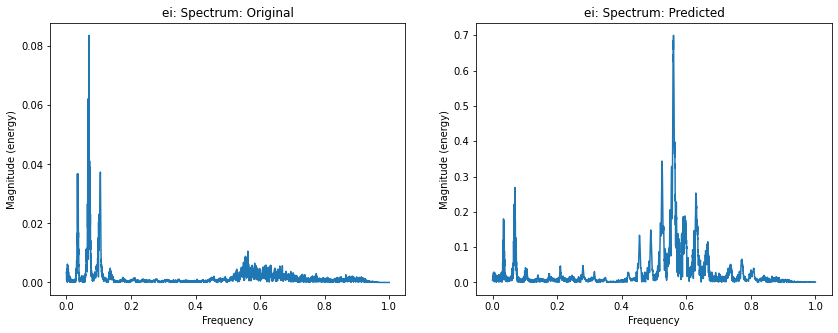

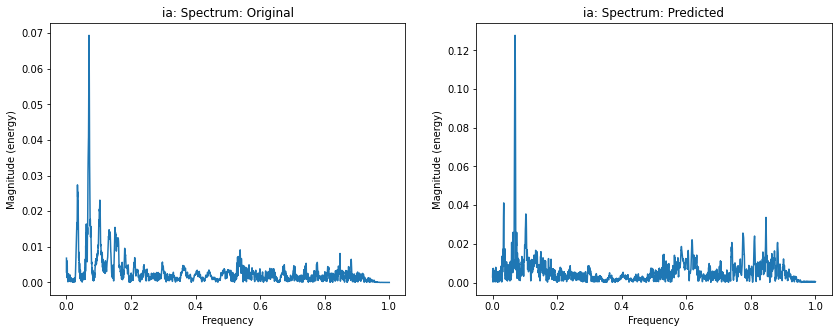

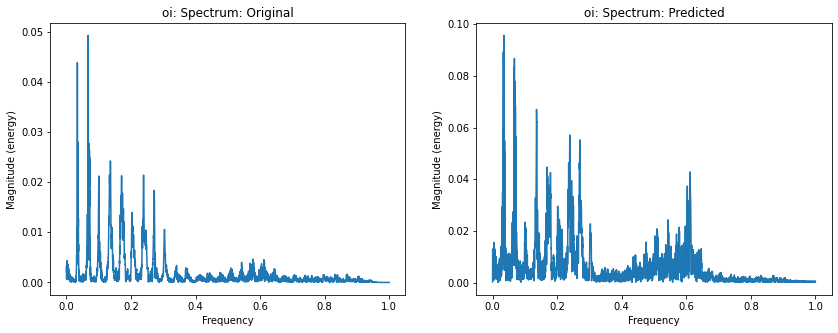

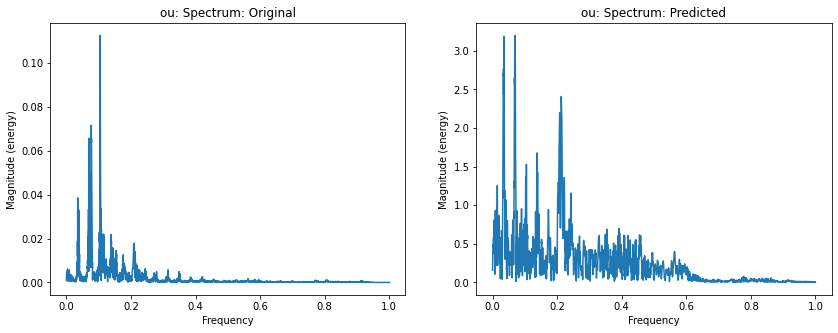

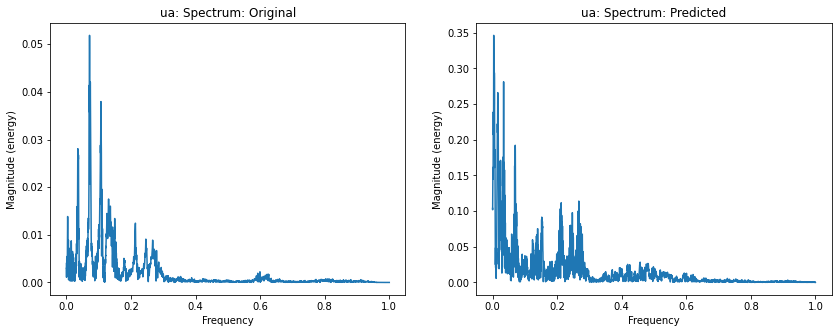

In [5]:
frame_size = 500
order = 10

Monothongs= ["a","aa","ae","ah","ahh","auh","auhh","e","i","ii","u","uu"]
Dipthongs= ["ai","au","ea","ei","ia","oi","ou","ua"]

for vowel in np.hstack([Monothongs,Dipthongs]):
    
    data, fs = librosa.load(vowel + ".wav", sr=8000)

    num_frames = int(len(data)/frame_size) 
    result = []
    
    for i in range(num_frames):
        d = data[i*frame_size: (i+1)*frame_size]
        phi = lpc_ref(d, order)
        a, e, k = lpc_levinson(phi, order)
        # print("LPC coeffs.: ",a) # Print LPC coefficients

        b = np.hstack([[0], -1 * a[1:]])
        y_hat = sig.lfilter(b, [1], d)
        result.append(y_hat)
        
    plt.figure(figsize=(14,5))
    plt.subplot(121)
    plt.magnitude_spectrum(data)
    plt.title(vowel + ": Spectrum: Original")
    plt.subplot(122)
    result = np.hstack(result)
    plt.magnitude_spectrum(result)
    plt.title(vowel + ": Spectrum: Predicted")
    plt.show()

In [6]:
# Covariance method

def lpc_phi(data,order):
    s=data
    p=order
    L=len(s)
    phi = np.zeros((p+1,p+1))
    
    def term(s,n):
        L=len(s)
        if n<0 or n>=L:
            return 0
        else:
            return s[n]

    for i in range(1,p+1):
        for k in range(p+1):
            for m in range(-k,L-k):
                phi[i,k]+= term(s,m)*term(s,m+k-i)
    
    return phi

# Cholesky decomposition
from scipy.linalg import cho_factor, cho_solve

def lpc_cholesky(phi):
    A = phi[1:,1:]
    c, low = cho_factor(A)
    a = cho_solve((c, low), phi[1:,0])
    return a

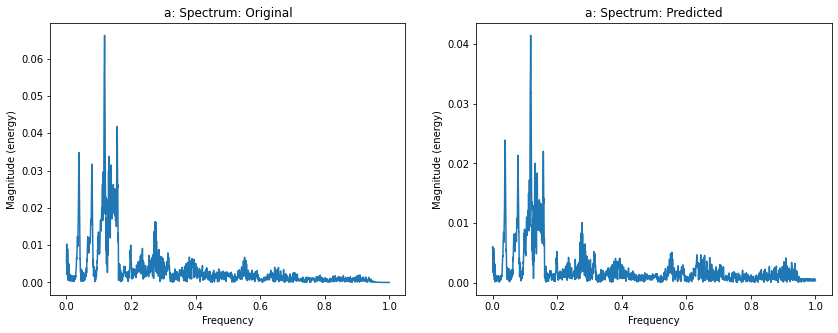

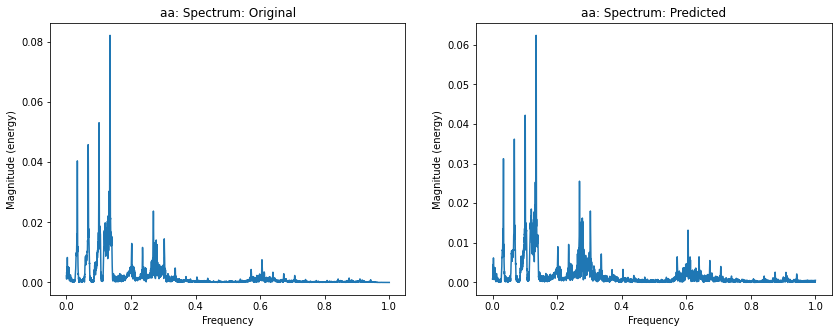

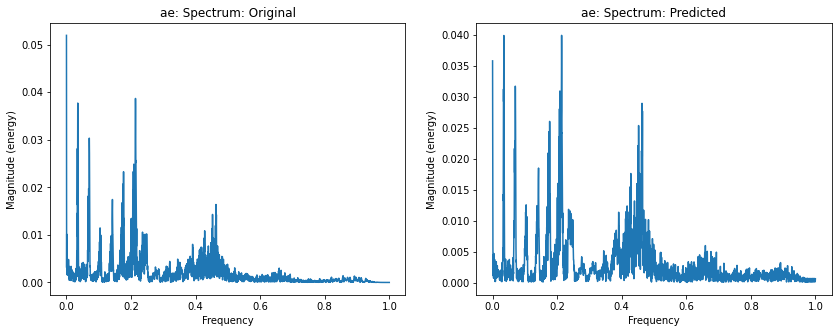

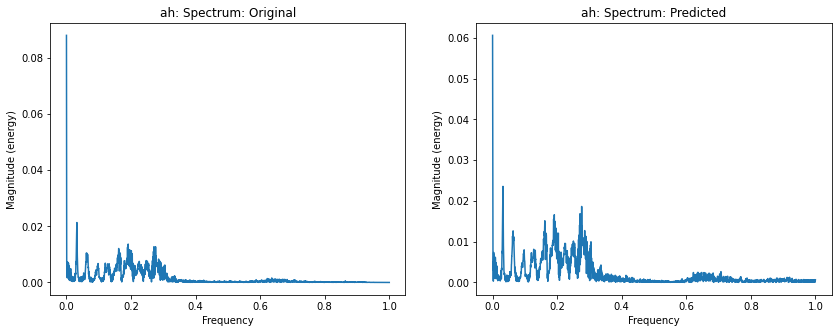

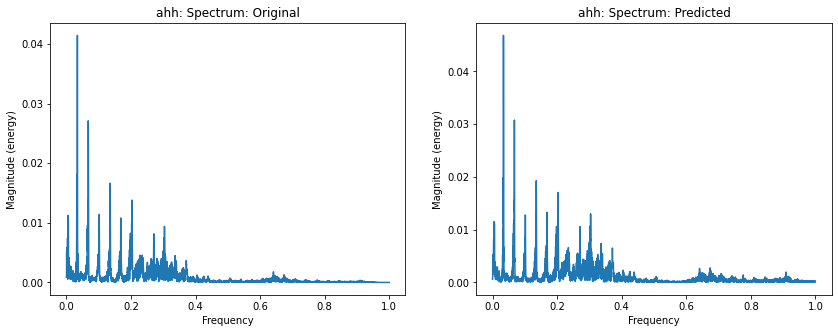

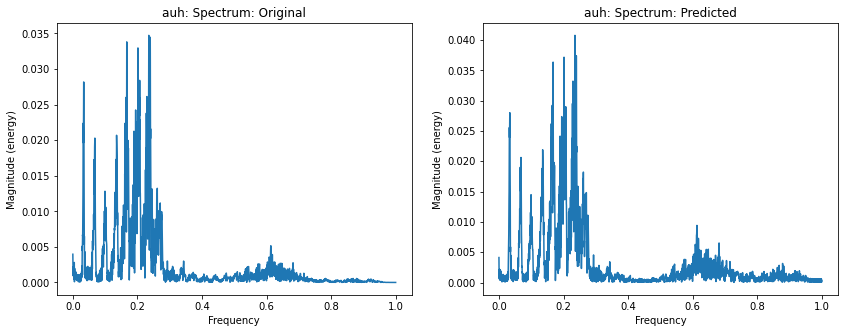

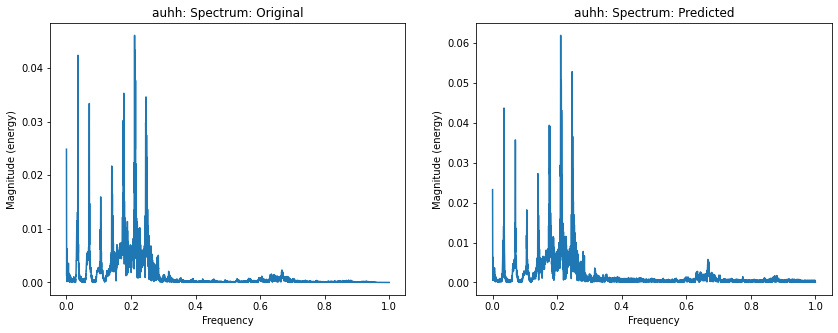

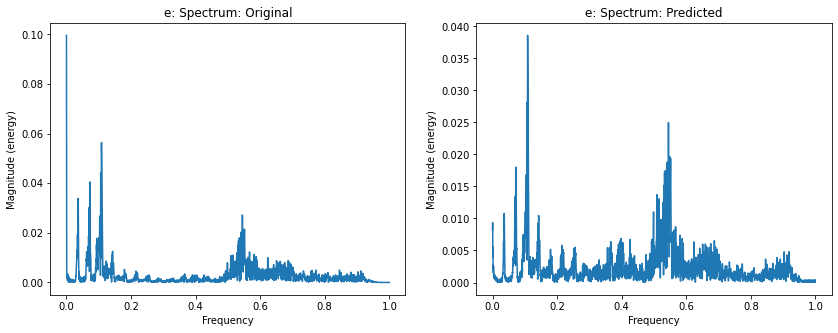

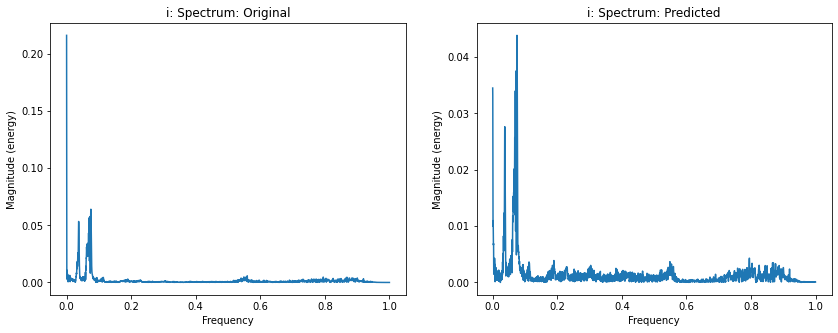

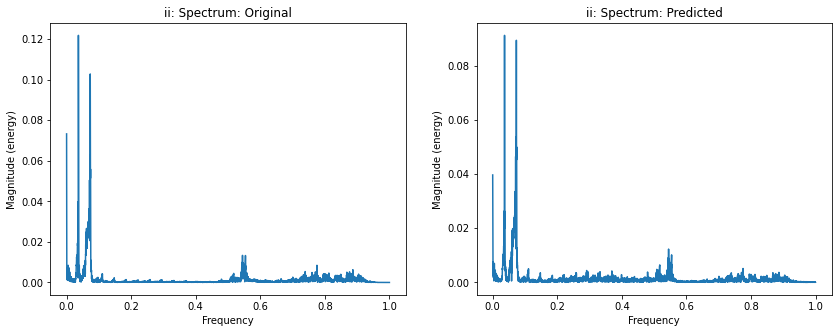

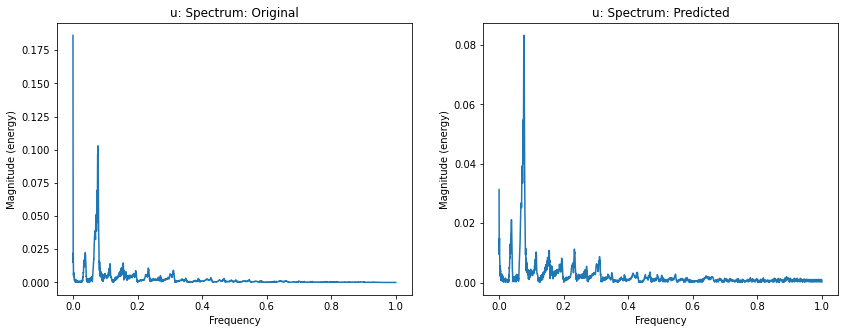

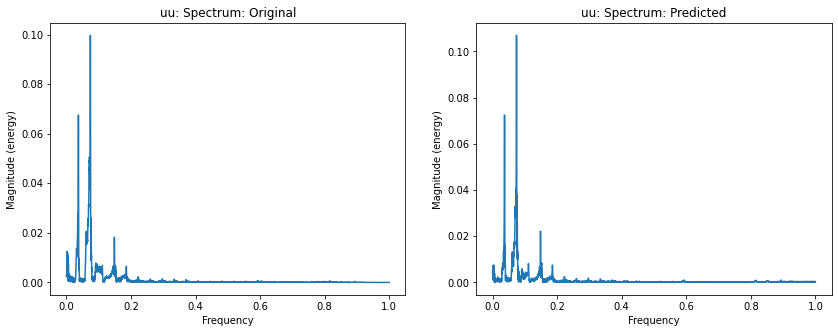

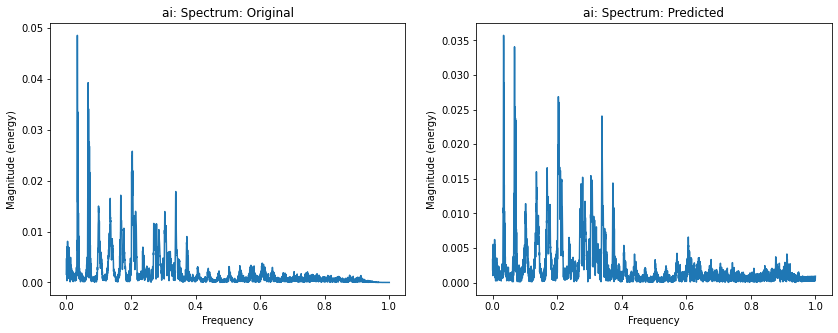

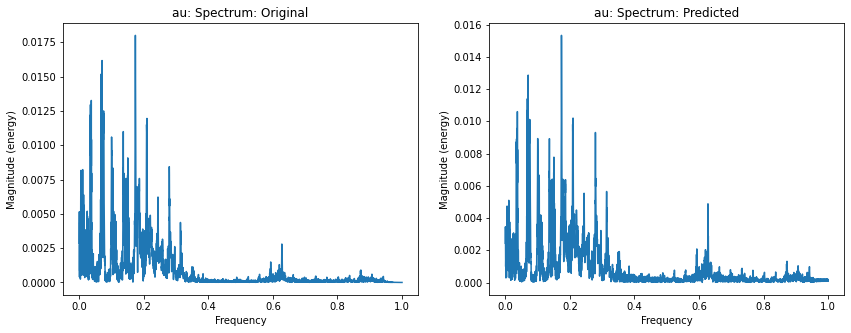

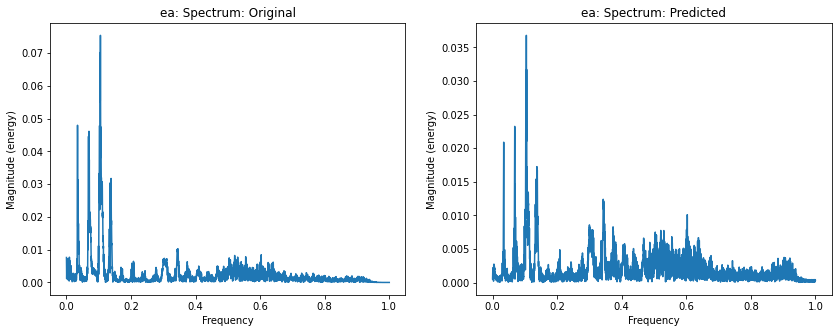

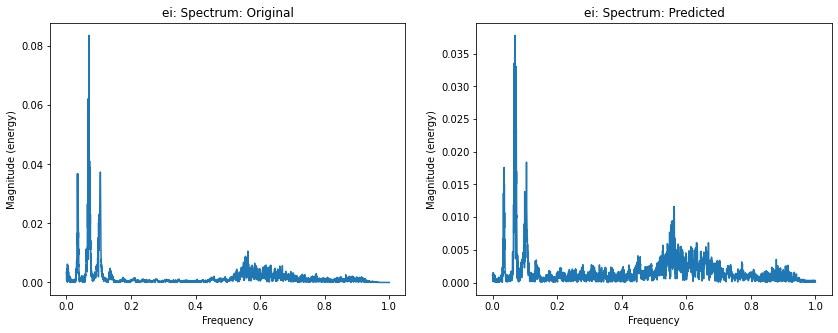

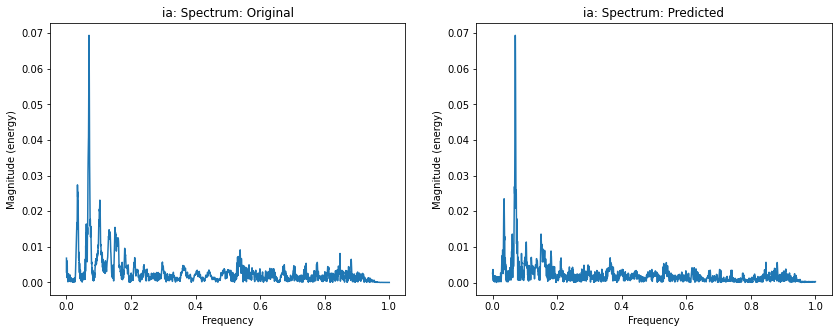

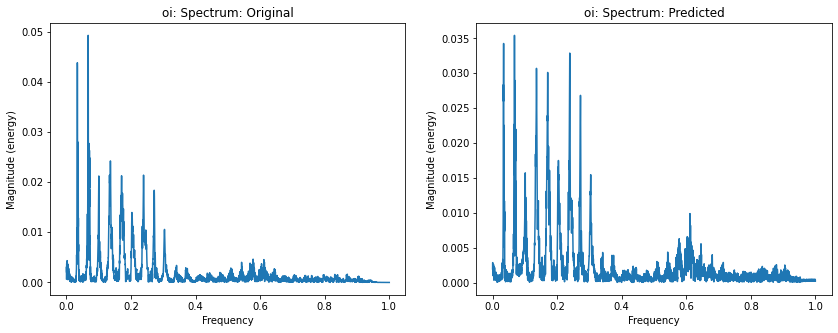

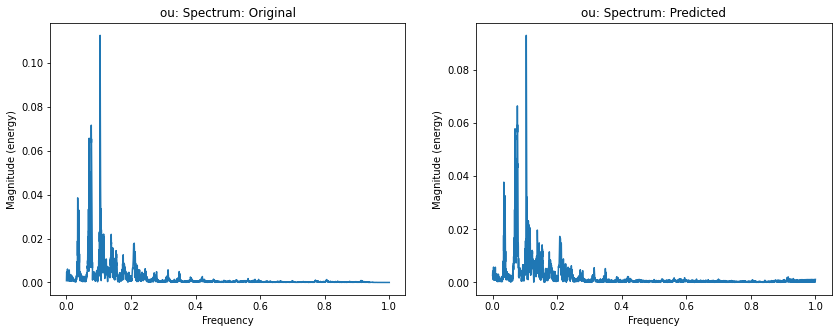

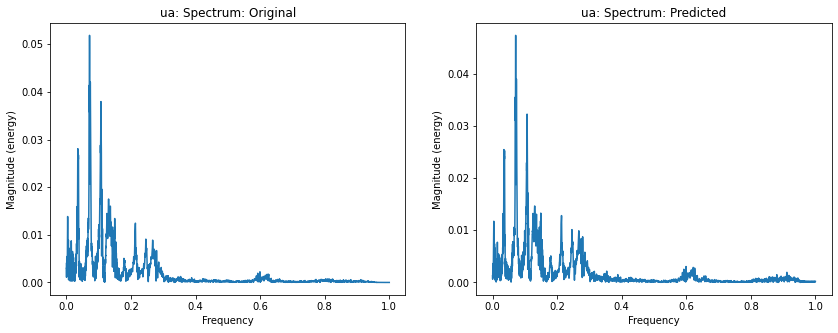

In [7]:
frame_size = 500
order = 10

Monothongs= ["a","aa","ae","ah","ahh","auh","auhh","e","i","ii","u","uu"]
Dipthongs= ["ai","au","ea","ei","ia","oi","ou","ua"]

for vowel in np.hstack([Monothongs,Dipthongs]):
    
    data, fs = librosa.load(vowel + ".wav", sr=8000)

    num_frames = int(len(data)/frame_size) 
    result = []
    
    for i in range(num_frames):
        d = data[i*frame_size: (i+1)*frame_size]
    
        phi = lpc_phi(d, order)            
        # print(phi.shape)

        a = lpc_cholesky(phi)
        # print("LPC coeffs.: ",a) # Print LPC coefficients
        b = np.hstack([[0], -1 * a[1:]])
        y_hat = sig.lfilter(b, [1], d)
        result.append(y_hat)
        
    plt.figure(figsize=(14,5))
    plt.subplot(121)
    plt.magnitude_spectrum(data)
    plt.title(vowel + ": Spectrum: Original")
    plt.subplot(122)
    result = np.hstack(result)
    plt.magnitude_spectrum(result)
    plt.title(vowel + ": Spectrum: Predicted")
    plt.show()

## Q2
Take any speech signal of your choose, find the STFT of it and synthesize the speech using the method over lap add.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

import librosa
import IPython.display as ipd
import soundfile

In [6]:
data, fs = librosa.load("sound.wav", sr=8000)
print("Length of data: ",len(data))
print("Sampling frequency: ",fs)
ipd.Audio("sound.wav")

Length of data:  26932
Sampling frequency:  8000


(24576,)
FFT size:  256
Hop size:  128
Total segments:  192


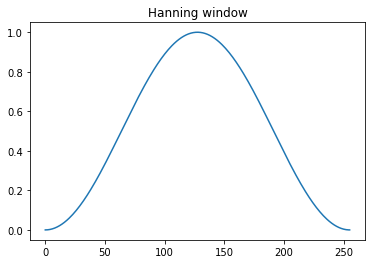

(192, 256)


In [7]:
data= data[:8192*3]
print(data.shape)
fft_size= 256 
overlap_fac= 0.5
 
hop_size = np.int32(np.floor(fft_size * (1-overlap_fac)))
pad_end_size = fft_size          
total_segments = np.int32(np.ceil(len(data) / np.float32(hop_size)))
t_max = len(data) / np.float32(fs)

print("FFT size: ",fft_size)
print("Hop size: ",hop_size)
print("Total segments: ",total_segments)

window = np.hanning(fft_size)  # our window
plt.plot(window)
plt.title("Hanning window")
plt.show()

inner_pad = np.zeros(fft_size) 
 
proc = np.concatenate((data, np.zeros(pad_end_size)))         
y_dB = np.empty((total_segments, fft_size), dtype=np.float32)   
y= np.empty((total_segments, fft_size), dtype=complex)
 
for i in range(total_segments):                   
    current_hop = hop_size * i                        
    segment = proc[current_hop:current_hop+fft_size]  
    windowed = segment * window                       # multiply by the half cosine function
    padded = np.append(windowed, inner_pad)           # add 0s to double the length of the data
    spectrum = np.fft.fft(padded)         # take the Fourier Transform and scale by the number of samples
    y[i,:] = np.fft.fft(windowed)
    autopower = np.abs(spectrum * np.conj(spectrum))  # find the autopower spectrum
    y_dB[i, :] = autopower[:fft_size]              
    
y_dB = 20*np.log10(y_dB)          # scale to db
# result = np.clip(result, -40, 200)    # clip values
print(y.shape)

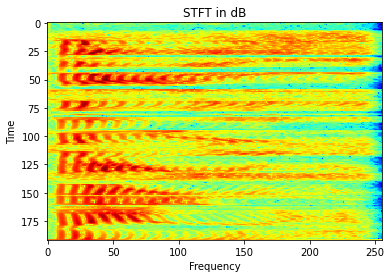

In [8]:
img = plt.imshow(y_dB, cmap='jet', interpolation='nearest', aspect='auto')
plt.xlabel("Frequency")
plt.ylabel("Time")
plt.title("STFT in dB")
plt.show()

In [9]:
# Synthesis using OLA

x=np.zeros(len(data)+hop_size)

for i in range(total_segments):
    current_hop = hop_size * i 
    x[current_hop:current_hop + fft_size]+= np.real(np.fft.ifft(y[i,:]))
    
print(np.shape(x))

(24704,)


In [14]:
soundfile.write("output.wav",x,fs)
ipd.Audio("output.wav")

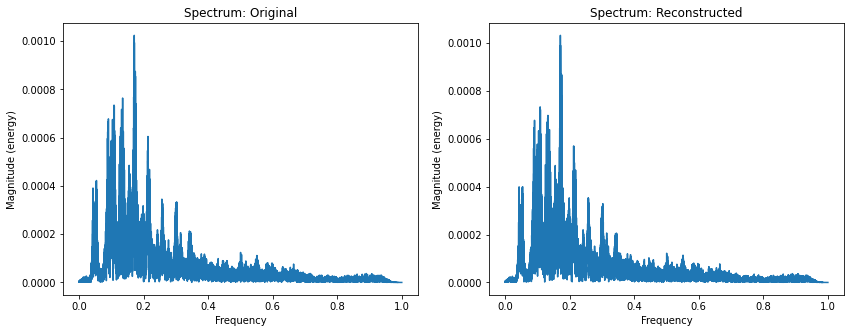

In [12]:
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.magnitude_spectrum(data)
plt.title("Spectrum: Original")
plt.subplot(122)
plt.magnitude_spectrum(x)
plt.title("Spectrum: Reconstructed")
plt.show()